In [1]:
import time

import numpy as np
import cv2
from scipy.spatial import Delaunay
import knn

import matplotlib.pyplot as plt

In [2]:
DEFINED = 0
UNDEFINED = 255

origin = (15, 15)
mask = cv2.imread("data/knn_unittest.png", cv2.IMREAD_GRAYSCALE)

In [3]:
def display_neighbors(mask: np.ndarray, origin: tuple, neighbors: list[tuple]):
    fig, axis = plt.subplots(1, 1, figsize=(6,6))
    axis.imshow(mask, cmap="Greys", alpha=0.5)
    axis.scatter(y=[origin[0]], x=[origin[1]], c="red")
    axis.scatter(y=[n[0] for n in neighbors], x=[n[1] for n in neighbors])
    
    axis.set_xticks([])
    axis.set_yticks([])

    plt.show()

In [4]:
def euclidean_distance(point1: tuple[int, int], point2: tuple[int, int]) -> float:
    p1_y, p1_x = point1
    p2_y, p2_x = point2

    return np.sqrt((p2_y - p1_y) ** 2 + (p2_x - p1_x) ** 2)

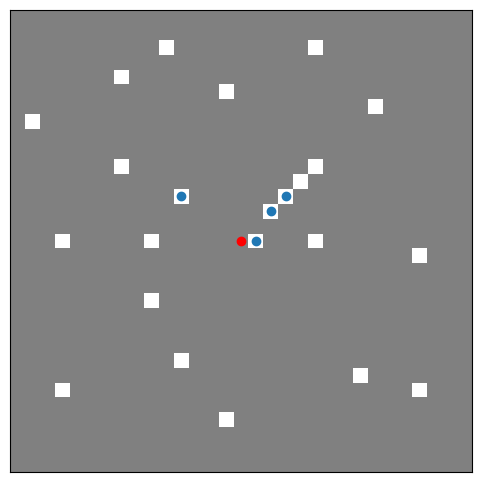

In [5]:
def nn_bruteforce(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
    neighbors = []
    height, width = mask.shape

    for y in range(height):
        for x in range(width):
            if mask[y, x] == DEFINED:
                neighbors.append((y, x, euclidean_distance(origin, (y, x))))
                
    neighbors = sorted(neighbors, key=lambda item: item[2])
    return neighbors[0: k]

neighbors = nn_bruteforce(mask, origin, 4)
display_neighbors(mask, origin, neighbors)

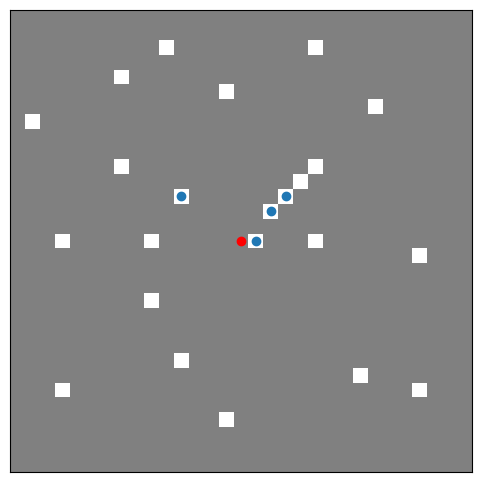

In [6]:
def nn_bruteforce_numpy(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
    neighbors = []
    candidates = np.argwhere(mask == DEFINED)
    for y, x in candidates:
        neighbors.append((y, x, euclidean_distance(origin, (y, x))))

    neighbors = sorted(neighbors, key=lambda item: item[2])
    return neighbors[0: k]

neighbors = nn_bruteforce(mask, origin, 4)
display_neighbors(mask, origin, neighbors)

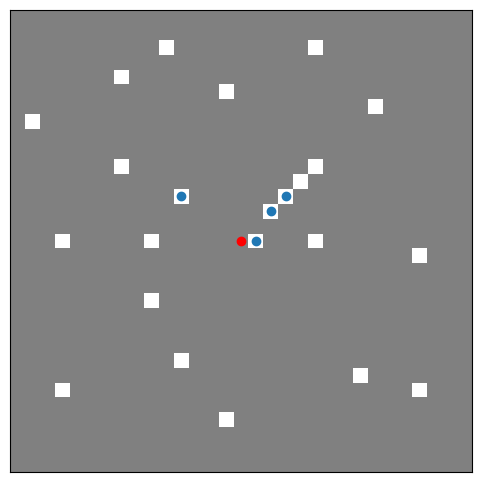

In [7]:
def expand(tri: Delaunay, index: int, queue: list, visited: list) -> None:
    neighbor_indices = tri.vertex_neighbor_vertices[1][tri.vertex_neighbor_vertices[0][index]: tri.vertex_neighbor_vertices[0][index+1]]
    for neighbor_index in neighbor_indices:
        if (neighbor_index not in visited):
            queue.append(neighbor_index)
            visited.append(neighbor_index)


def nn_delaunay(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
    neighbors, queue, visited  = [], [], []
    radius = np.inf
    tri = Delaunay(np.argwhere(mask == DEFINED), incremental=True)  # do this only once later
    tri.add_points([origin])

    start_node_index = np.argwhere((tri.points == origin).all(axis=1)).item()
    expand(tri, start_node_index, queue, visited)
    visited.append(start_node_index)
    while queue:
        index = queue.pop(0)
        
        p_y, p_x = tri.points[index]
        d = euclidean_distance(origin, (p_y, p_x))
        if d > radius:
            continue

        neighbors.append((p_y, p_x, d))
        neighbors = sorted(neighbors, key=lambda item: item[2])
        neighbors = neighbors[0: k]
        if len(neighbors) == k:
            radius = neighbors[-1][2]

        expand(tri, index, queue, visited)

    # fig, axis = plt.subplots(1, 1, figsize=(6,6))
    # axis.imshow(mask, cmap="Greys", alpha=0.5)
    # axis.triplot(tri.points[:,1], tri.points[:,0], tri.simplices)
    # axis.scatter(y=[origin[0]], x=[origin[1]], c="red")
    # plt.show()

    return neighbors

neighbors = nn_delaunay(mask, origin, 4)
display_neighbors(mask, origin, neighbors)

In [8]:
# mask = np.random.rand(400 * 400).reshape(400, 400)
# mask = np.where(mask < 0.01, 0, 255)
# neighbors = nn_delaunay(mask, (200, 200), 4)
# display_neighbors(mask, (200, 200), neighbors)

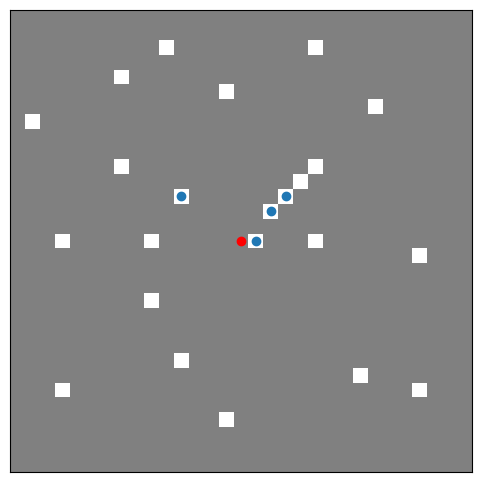

In [9]:
def nn_quadratic(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
    neighbors = []
    origin_y, origin_x = origin
    height, width = mask.shape

    max_distance = max(origin_y, height - origin_y, origin_x, width - origin_x)

    for distance in range(1, max_distance):
        y_t, y_b = origin_y - distance, origin_y + distance
        x_l, x_r = origin_x - distance, origin_x + distance

        for y in range(y_t, y_b + 1):
            if 0 <= y < height:
                if x_l >= 0 and mask[y, x_l] == DEFINED:
                    neighbors.append((y, x_l, euclidean_distance(origin, (y, x_l))))
                if x_r < width and mask[y, x_r] == DEFINED:
                    neighbors.append((y, x_r, euclidean_distance(origin, (y, x_r))))

        for x in range(x_l + 1, x_r):
            if 0 <= x < width:
                if y_t >= 0 and mask[y_t, x] == DEFINED:
                    neighbors.append((y_t, x, euclidean_distance(origin, (y_t, x))))
                if y_b < height and mask[y_b, x] == DEFINED:
                    neighbors.append((y_b, x, euclidean_distance(origin, (y_b, x))))

        if len(neighbors) >= k:
            neighbors = sorted(neighbors, key=lambda item: item[2])
            neighbors = neighbors[0 :k]
            if neighbors[-1][2] < distance:
                break

    return neighbors

neighbors = nn_quadratic(mask, origin, 4)
display_neighbors(mask, origin, neighbors)

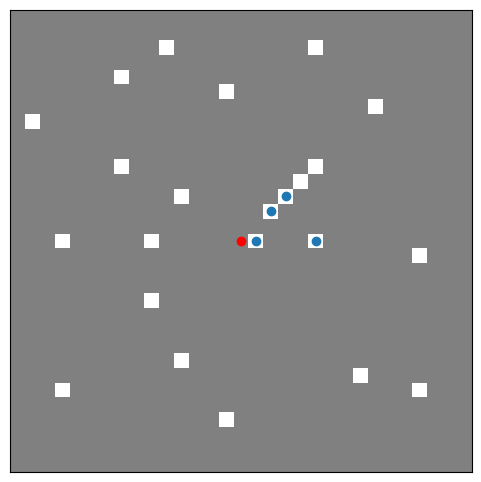

In [10]:
def nn_circle(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
    neighbors = set()
    origin_y, origin_x = origin
    height, width = mask.shape

    furthest_pixel = round(max(euclidean_distance(origin, (0, 0)), euclidean_distance(origin, (height, 0)), euclidean_distance(origin, (0, width)), euclidean_distance(origin, (height, width))))

    discretization = np.linspace(0, 2, 360) * np.pi
    for distance in range(1, furthest_pixel):
        Y = np.round(distance * np.cos(discretization) + origin_y).astype(int)
        X = np.round(distance * np.sin(discretization) + origin_x).astype(int)

        for y, x in zip(Y, X):
            if 0 <= y < height and 0 <= x < width and mask[y, x] == DEFINED:
                neighbors.add((y, x))
                if len(neighbors) == k:
                    return list(neighbors)

    return list(neighbors)

neighbors = nn_circle(mask, origin, 4)
display_neighbors(mask, origin, neighbors)

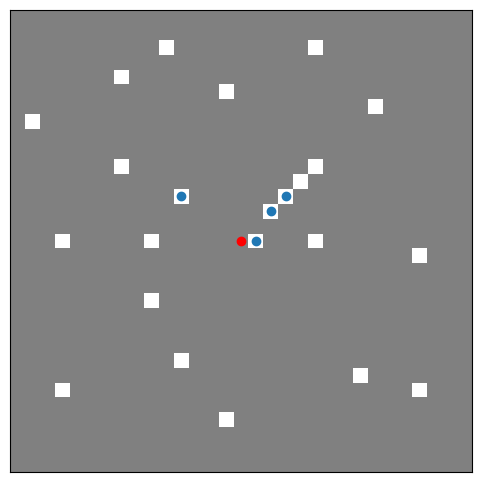

In [13]:
def nn_circle_opt(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
    height, width = mask.shape

    furthest_pixel = round(max(euclidean_distance(origin, (0, 0)), euclidean_distance(origin, (height, 0)), euclidean_distance(origin, (0, width)), euclidean_distance(origin, (height, width))))

    discretization = np.linspace(0, 2, 360) * np.pi
    neighbors = knn.nn_circular(mask, origin, discretization, furthest_pixel, k)

    return list(neighbors)

neighbors = nn_circle_opt(mask, origin, 4)
display_neighbors(mask, origin, neighbors)

In [15]:
import unittest

class TestNN(unittest.TestCase):

    def get_default_mask_params(self):
        origin = (15, 15)
        mask = cv2.imread("data/knn_unittest.png", cv2.IMREAD_GRAYSCALE)
        k = 4
        gt = [(15, 16), (15, 20), (13, 17), (12, 18), (12, 11)]

        return mask, origin, k, gt
    
    def get_quadratic_mask_params_corner(self):
        origin = (15, 15)
        mask = np.full((31, 31), 255)
        mask[1, 1] = 0
        mask[29, 29] = 0
        mask[15, 0] = 0
        mask[15, 30] = 0
        k = 2
        gt = [(15, 0), (15, 30)]

        return mask, origin, k, gt
    
    def get_circle_mask_params_corner(self):
        origin = (15, 15)
        mask = np.full((31, 31), 255)
        mask[0, 0] = 0
        mask[30, 30] = 0
        k = 2
        gt = [(0, 0), (30, 30)]

        return mask, origin, k, gt

    def test_bruteforce_default(self):
        mask, origin, k, gt = self.get_default_mask_params()
        neighbors = nn_bruteforce(mask, origin, k)
        neighbors = [(n[0], n[1]) for n in neighbors]
        self.assertTrue(set(gt).issuperset(set(neighbors)))

    def test_delaunay_default(self):
        mask, origin, k, gt = self.get_default_mask_params()
        neighbors = nn_delaunay(mask, origin, k)
        neighbors = [(n[0], n[1]) for n in neighbors]
        self.assertTrue(set(gt).issuperset(set(neighbors)))

    def test_quadratic_default(self):
        mask, origin, k, gt = self.get_default_mask_params()
        neighbors = nn_quadratic(mask, origin, k)
        neighbors = [(n[0], n[1]) for n in neighbors]
        self.assertTrue(set(gt).issuperset(set(neighbors)))

    def test_circle_default(self):
        mask, origin, k, gt = self.get_default_mask_params()
        neighbors = nn_circle(mask, origin, k)
        neighbors = [(n[0], n[1]) for n in neighbors]
        self.assertTrue(set(gt).issuperset(set(neighbors)))

    def test_circle_opt_default(self):
        mask, origin, k, gt = self.get_default_mask_params()
        neighbors = nn_circle_opt(mask, origin, k)
        neighbors = [(n[0], n[1]) for n in neighbors]
        self.assertTrue(set(gt).issuperset(set(neighbors)))

    def test_quadratic_corner(self):
        mask, origin, k, gt = self.get_quadratic_mask_params_corner()
        neighbors = nn_quadratic(mask, origin, k)
        neighbors = [(n[0], n[1]) for n in neighbors]
        self.assertTrue(set(gt).issuperset(set(neighbors)))

    def test_circle_corner(self):
        mask, origin, k, gt = self.get_circle_mask_params_corner()
        neighbors = nn_circle(mask, origin, k)
        neighbors = [(n[0], n[1]) for n in neighbors]
        self.assertTrue(set(gt).issuperset(set(neighbors)))

    def test_circle_opt_corner(self):
        mask, origin, k, gt = self.get_circle_mask_params_corner()
        neighbors = nn_circle_opt(mask, origin, k)
        neighbors = [(n[0], n[1]) for n in neighbors]
        self.assertTrue(set(gt).issuperset(set(neighbors)))


unittest.main(argv=[""], verbosity=1, exit=False)

........
----------------------------------------------------------------------
Ran 8 tests in 0.015s

OK


In [16]:
%load_ext line_profiler

In [17]:
def test_nn_general(shape, fill_factor, k,  nn_f):
    mask = np.random.rand(shape[0] * shape[1]).reshape(shape)
    mask = np.where(mask < fill_factor, 0, 255)
    origin = (shape[0] // 2, shape[1] // 2)
    t1 = time.time()
    nn_f(mask, origin, k)
    print(f"{nn_f}: {time.time() - t1}; {shape} - {fill_factor}")

In [33]:
for shape in [(400, 400), (1000, 1000), (2000, 2000)]:
    for fill_factor in [0.001, 0.01, 0.1, 0.25, 0.5]:
        test_nn_general(shape, fill_factor, 10, nn_bruteforce)

<function nn_bruteforce at 0x79136c1789a0>: 0.0284271240234375; (400, 400) - 0.001
<function nn_bruteforce at 0x79136c1789a0>: 0.026180744171142578; (400, 400) - 0.01
<function nn_bruteforce at 0x79136c1789a0>: 0.04604339599609375; (400, 400) - 0.1
<function nn_bruteforce at 0x79136c1789a0>: 0.08840155601501465; (400, 400) - 0.25
<function nn_bruteforce at 0x79136c1789a0>: 0.1410977840423584; (400, 400) - 0.5
<function nn_bruteforce at 0x79136c1789a0>: 0.13036465644836426; (1000, 1000) - 0.001
<function nn_bruteforce at 0x79136c1789a0>: 0.14449644088745117; (1000, 1000) - 0.01
<function nn_bruteforce at 0x79136c1789a0>: 0.26801562309265137; (1000, 1000) - 0.1
<function nn_bruteforce at 0x79136c1789a0>: 0.5057053565979004; (1000, 1000) - 0.25
<function nn_bruteforce at 0x79136c1789a0>: 0.9204318523406982; (1000, 1000) - 0.5
<function nn_bruteforce at 0x79136c1789a0>: 0.4778709411621094; (2000, 2000) - 0.001
<function nn_bruteforce at 0x79136c1789a0>: 0.5631203651428223; (2000, 2000) - 0

In [34]:
for shape in [(400, 400), (1000, 1000), (2000, 2000)]:
    for fill_factor in [0.001, 0.01, 0.1, 0.25, 0.5]:
        test_nn_general(shape, fill_factor, 10, nn_bruteforce_numpy)

<function nn_bruteforce_numpy at 0x79136c1dfba0>: 0.0012433528900146484; (400, 400) - 0.001
<function nn_bruteforce_numpy at 0x79136c1dfba0>: 0.0051422119140625; (400, 400) - 0.01
<function nn_bruteforce_numpy at 0x79136c1dfba0>: 0.03774714469909668; (400, 400) - 0.1
<function nn_bruteforce_numpy at 0x79136c1dfba0>: 0.08663654327392578; (400, 400) - 0.25
<function nn_bruteforce_numpy at 0x79136c1dfba0>: 0.18125128746032715; (400, 400) - 0.5
<function nn_bruteforce_numpy at 0x79136c1dfba0>: 0.004316806793212891; (1000, 1000) - 0.001
<function nn_bruteforce_numpy at 0x79136c1dfba0>: 0.02398538589477539; (1000, 1000) - 0.01
<function nn_bruteforce_numpy at 0x79136c1dfba0>: 0.2292952537536621; (1000, 1000) - 0.1
<function nn_bruteforce_numpy at 0x79136c1dfba0>: 0.6056149005889893; (1000, 1000) - 0.25
<function nn_bruteforce_numpy at 0x79136c1dfba0>: 1.1970953941345215; (1000, 1000) - 0.5
<function nn_bruteforce_numpy at 0x79136c1dfba0>: 0.01681804656982422; (2000, 2000) - 0.001
<function n

In [35]:
for shape in [(400, 400), (1000, 1000), (2000, 2000)]:
    for fill_factor in [0.001, 0.01, 0.1, 0.25, 0.5]:
        test_nn_general(shape, fill_factor, 10, nn_delaunay)

<function nn_delaunay at 0x79136c1dfd80>: 0.0020062923431396484; (400, 400) - 0.001
<function nn_delaunay at 0x79136c1dfd80>: 0.006869792938232422; (400, 400) - 0.01
<function nn_delaunay at 0x79136c1dfd80>: 0.09511685371398926; (400, 400) - 0.1
<function nn_delaunay at 0x79136c1dfd80>: 0.23966121673583984; (400, 400) - 0.25
<function nn_delaunay at 0x79136c1dfd80>: 0.7039706707000732; (400, 400) - 0.5
<function nn_delaunay at 0x79136c1dfd80>: 0.005733489990234375; (1000, 1000) - 0.001
<function nn_delaunay at 0x79136c1dfd80>: 0.040587663650512695; (1000, 1000) - 0.01
<function nn_delaunay at 0x79136c1dfd80>: 0.7570219039916992; (1000, 1000) - 0.1
<function nn_delaunay at 0x79136c1dfd80>: 2.5285494327545166; (1000, 1000) - 0.25
<function nn_delaunay at 0x79136c1dfd80>: 5.877891778945923; (1000, 1000) - 0.5
<function nn_delaunay at 0x79136c1dfd80>: 0.023772716522216797; (2000, 2000) - 0.001
<function nn_delaunay at 0x79136c1dfd80>: 0.17784428596496582; (2000, 2000) - 0.01
<function nn_d

In [36]:
for shape in [(400, 400), (1000, 1000), (2000, 2000)]:
    for fill_factor in [0.001, 0.01, 0.1, 0.25, 0.5]:
        test_nn_general(shape, fill_factor, 10, nn_quadratic)

<function nn_quadratic at 0x79136ad70680>: 0.001970052719116211; (400, 400) - 0.001
<function nn_quadratic at 0x79136ad70680>: 0.00035452842712402344; (400, 400) - 0.01
<function nn_quadratic at 0x79136ad70680>: 0.0001068115234375; (400, 400) - 0.1
<function nn_quadratic at 0x79136ad70680>: 0.00011491775512695312; (400, 400) - 0.25
<function nn_quadratic at 0x79136ad70680>: 8.654594421386719e-05; (400, 400) - 0.5
<function nn_quadratic at 0x79136ad70680>: 0.0016314983367919922; (1000, 1000) - 0.001
<function nn_quadratic at 0x79136ad70680>: 0.0003733634948730469; (1000, 1000) - 0.01
<function nn_quadratic at 0x79136ad70680>: 0.00011897087097167969; (1000, 1000) - 0.1
<function nn_quadratic at 0x79136ad70680>: 4.935264587402344e-05; (1000, 1000) - 0.25
<function nn_quadratic at 0x79136ad70680>: 8.487701416015625e-05; (1000, 1000) - 0.5
<function nn_quadratic at 0x79136ad70680>: 0.0018970966339111328; (2000, 2000) - 0.001
<function nn_quadratic at 0x79136ad70680>: 0.00041294097900390625;

In [37]:
for shape in [(400, 400), (1000, 1000), (2000, 2000)]:
    for fill_factor in [0.001, 0.01, 0.1, 0.25, 0.5]:
        test_nn_general(shape, fill_factor, 10, nn_circle)

<function nn_circle at 0x79136ad5bc40>: 0.010855436325073242; (400, 400) - 0.001
<function nn_circle at 0x79136ad5bc40>: 0.004110574722290039; (400, 400) - 0.01
<function nn_circle at 0x79136ad5bc40>: 0.0009670257568359375; (400, 400) - 0.1
<function nn_circle at 0x79136ad5bc40>: 0.0006577968597412109; (400, 400) - 0.25
<function nn_circle at 0x79136ad5bc40>: 0.0007066726684570312; (400, 400) - 0.5
<function nn_circle at 0x79136ad5bc40>: 0.010342121124267578; (1000, 1000) - 0.001
<function nn_circle at 0x79136ad5bc40>: 0.0037093162536621094; (1000, 1000) - 0.01
<function nn_circle at 0x79136ad5bc40>: 0.0008401870727539062; (1000, 1000) - 0.1
<function nn_circle at 0x79136ad5bc40>: 0.00049591064453125; (1000, 1000) - 0.25
<function nn_circle at 0x79136ad5bc40>: 0.0004456043243408203; (1000, 1000) - 0.5
<function nn_circle at 0x79136ad5bc40>: 0.01018834114074707; (2000, 2000) - 0.001
<function nn_circle at 0x79136ad5bc40>: 0.003976583480834961; (2000, 2000) - 0.01
<function nn_circle at 

In [18]:
for shape in [(400, 400), (1000, 1000), (2000, 2000)]:
    for fill_factor in [0.001, 0.01, 0.1, 0.25, 0.5]:
        test_nn_general(shape, fill_factor, 10, nn_circle_opt)

<function nn_circle_opt at 0x743016dab880>: 0.0002906322479248047; (400, 400) - 0.001
<function nn_circle_opt at 0x743016dab880>: 0.00018787384033203125; (400, 400) - 0.01
<function nn_circle_opt at 0x743016dab880>: 9.512901306152344e-05; (400, 400) - 0.1
<function nn_circle_opt at 0x743016dab880>: 7.581710815429688e-05; (400, 400) - 0.25
<function nn_circle_opt at 0x743016dab880>: 8.96453857421875e-05; (400, 400) - 0.5
<function nn_circle_opt at 0x743016dab880>: 0.00028204917907714844; (1000, 1000) - 0.001
<function nn_circle_opt at 0x743016dab880>: 0.00015854835510253906; (1000, 1000) - 0.01
<function nn_circle_opt at 0x743016dab880>: 9.417533874511719e-05; (1000, 1000) - 0.1
<function nn_circle_opt at 0x743016dab880>: 6.532669067382812e-05; (1000, 1000) - 0.25
<function nn_circle_opt at 0x743016dab880>: 6.604194641113281e-05; (1000, 1000) - 0.5
<function nn_circle_opt at 0x743016dab880>: 0.0002295970916748047; (2000, 2000) - 0.001
<function nn_circle_opt at 0x743016dab880>: 0.000114

In [19]:
mask = np.random.rand(1000 * 1000).reshape((1000, 1000))
mask = np.where(mask < 0.01, 0, 255)
origin = (500, 500)
k = 4

In [121]:
%lprun -f nn_bruteforce nn_bruteforce(mask, origin, k)

Timer unit: 1e-09 s

Total time: 0.404798 s
File: /tmp/ipykernel_40439/1595391075.py
Function: nn_bruteforce at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def nn_bruteforce(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
     2         1        962.0    962.0      0.0      neighbors = []
     3         1       2394.0   2394.0      0.0      height, width = mask.shape
     4                                           
     5      1001     128756.0    128.6      0.0      for y in range(height):
     6   1001000  136473792.0    136.3     33.7          for x in range(width):
     7   1000000  246849363.0    246.8     61.0              if mask[y, x] == DEFINED:
     8     10186   17682635.0   1736.0      4.4                  neighbors.append((y, x, euclidean_distance(origin, (y, x))))
     9                                                           
    10         1    3657921.0    4e+06      0.9      neighb

In [122]:

%lprun -f nn_bruteforce_numpy nn_bruteforce_numpy(mask, origin, k)

Timer unit: 1e-09 s

Total time: 0.042119 s
File: /tmp/ipykernel_40439/2638980425.py
Function: nn_bruteforce_numpy at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def nn_bruteforce_numpy(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
     2         1        471.0    471.0      0.0      neighbors = []
     3         1    2158867.0    2e+06      5.1      candidates = np.argwhere(mask == DEFINED)
     4     10187   11173888.0   1096.9     26.5      for y, x in candidates:
     5     10186   22751678.0   2233.6     54.0          neighbors.append((y, x, euclidean_distance(origin, (y, x))))
     6                                           
     7         1    6032401.0    6e+06     14.3      neighbors = sorted(neighbors, key=lambda item: item[2])
     8         1       1743.0   1743.0      0.0      return neighbors[0: k]

In [123]:
%lprun -f nn_delaunay nn_delaunay(mask, origin, k)

Timer unit: 1e-09 s

Total time: 0.0553866 s
File: /tmp/ipykernel_40439/806411042.py
Function: nn_delaunay at line 9

Line #      Hits         Time  Per Hit   % Time  Line Contents
     9                                           def nn_delaunay(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
    10         1        761.0    761.0      0.0      neighbors, queue, visited  = [], [], []
    11         1       1032.0   1032.0      0.0      radius = np.inf
    12         1   48096680.0    5e+07     86.8      tri = Delaunay(np.argwhere(mask == DEFINED), incremental=True)  # do this only once later
    13         1    4903570.0    5e+06      8.9      tri.add_points([origin])
    14                                           
    15         1     231513.0 231513.0      0.4      start_node_index = np.argwhere((tri.points == origin).all(axis=1)).item()
    16         1    1968261.0    2e+06      3.6      expand(tri, start_node_index, queue, visited)
    17         1        221.0    221.0

In [124]:
%lprun -f nn_quadratic nn_quadratic(mask, origin, k)

Timer unit: 1e-09 s

Total time: 0.000837343 s
File: /tmp/ipykernel_40439/3799269253.py
Function: nn_quadratic at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def nn_quadratic(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
     2         1       1022.0   1022.0      0.1      neighbors = []
     3         1        661.0    661.0      0.1      origin_y, origin_x = origin
     4         1       2214.0   2214.0      0.3      height, width = mask.shape
     5                                           
     6         1       2234.0   2234.0      0.3      max_distance = max(origin_y, height - origin_y, origin_x, width - origin_x)
     7                                           
     8        13       4917.0    378.2      0.6      for distance in range(1, max_distance):
     9        13       4922.0    378.6      0.6          y_t, y_b = origin_y - distance, origin_y + distance
    10        13       4139.0   

In [125]:
%lprun -f nn_circle nn_circle(mask, origin, k)

Timer unit: 1e-09 s

Total time: 0.00738337 s
File: /tmp/ipykernel_40439/1203335792.py
Function: nn_circle at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def nn_circle(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
     2         1        931.0    931.0      0.0      neighbors = set()
     3         1        291.0    291.0      0.0      origin_y, origin_x = origin
     4         1       1823.0   1823.0      0.0      height, width = mask.shape
     5                                           
     6         1      43001.0  43001.0      0.6      furthest_pixel = round(max(euclidean_distance(origin, (0, 0)), euclidean_distance(origin, (height, 0)), euclidean_distance(origin, (0, width)), euclidean_distance(origin, (height, width))))
     7                                           
     8         1      84869.0  84869.0      1.1      discretization = np.linspace(0, 2, 360) * np.pi
     9        13       

In [20]:
%lprun -f nn_circle_opt nn_circle_opt(mask, origin, k)

Timer unit: 1e-09 s

Total time: 0.000193483 s
File: /tmp/ipykernel_56910/679757888.py
Function: nn_circle_opt at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def nn_circle_opt(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
     2         1       2165.0   2165.0      1.1      height, width = mask.shape
     3                                           
     4         1      37741.0  37741.0     19.5      furthest_pixel = round(max(euclidean_distance(origin, (0, 0)), euclidean_distance(origin, (height, 0)), euclidean_distance(origin, (0, width)), euclidean_distance(origin, (height, width))))
     5                                           
     6         1      74249.0  74249.0     38.4      discretization = np.linspace(0, 2, 360) * np.pi
     7         1      78096.0  78096.0     40.4      neighbors = knn.nn_circular(mask, origin, discretization, furthest_pixel, k)
     8                               